In [3]:
import time, os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import urllib
import requests
import sys
from IPython.display import Image, display

In [ ]:
def launch_browser(url):
    # path to the chromedriver executable
    chromedriver = r"C:\Users\tyler\Documents\GitHub\chromedriver.exe"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver) #launch the browser
    driver.get(url)
    return driver

In [ ]:
def get_url_list(url_list):
    '''
    parse list of target urls to be scraped
    '''
    return_list = []
    for url in url_list:
        flower_link = url.get_attribute('href')
        if '/plants/group' in flower_link and len(flower_link) > 33 and 'facebook' not in flower_link:
            return_list.append(flower_link)
    return return_list

In [ ]:
def get_flower_name(url):
    flower = url.replace('https://garden.org/plants/group/', '')
    flower = flower.replace('/', '')
    return flower

In [ ]:
def loop_through_url_list(url_list):
    '''
    This function receives a list of URLs, and loops through those. For each URL
    it go into the page, click an 'Access the generic daylilies entry' button, 
    then save all of those thumbnail images into a folder.
    Note: saving thumbnails for the sake of space
    ---
    input: a list of string URLs and an empty dataframe
    output: a dataframe with data from each URL in the list
    '''
    x=1
    for url in url_list:
        flower = get_flower_name(url)
        print('fetching images for', x, 'of', len(url_list), flower)
        #go to flower page
        driver.get(url)
        
        link_list = driver.find_elements_by_css_selector('p a')
        for link in link_list:
            link = link.get_attribute('href')
            if "/plants/view/" in link:
                target = link
        
        #save each thumbnail image
        pic_list = save_each_flower_picture(target, flower)
        
        x+=1
    print('done!!')

In [ ]:
def save_each_flower_picture(url, flower, x):
    save_location = 'C:/Users/tyler/Desktop/flowers'
    driver.get(url)
    exclusions = ['Image', 
                    'Login to give thumbs-ups', 
                    'https://garden.org/i/icon/tu-green.png', 
                    'https://garden.org/i/p/social/pinterest.png',
                    'https://garden.org/i/p/social/facebook.png',
                    'https://garden.org/i/p/social/linkedin.png',
                    'https://garden.org/i/p/social/twitter.png',
                    'https://garden.org/i/p/social/gmail.png',
                    'https://garden.org/i/p/nga/header/logo.png',
                    'https://garden.org/i/p/nga/header/plants.png',
                    'https://garden.org/i/p/newsletter_signup.png'
                 ]
    #save each THUMBNAIL with naming convention of "flower (scientific name), iterator"
    #this can be found at the top of each page
    
    pic_list = driver.find_elements_by_css_selector('a img')
    for pic in pic_list:
        title = pic.get_attribute('title')
        flower_link = pic.get_attribute('src')
        
        if title not in exclusions and flower_link not in exclusions:
            try:
                with open("C:/Users/tyler/Desktop/flowers/"+flower+"_"+str(x)+".jpg", "wb") as f:
                    f.write(requests.get(flower_link).content)
            except:
                pass
                print('fail')
            x+=1    
    return x #number of pictures so far -- in order to not overwrite when at new species

In [ ]:
# loop_through_url_list(url_list)

In [ ]:
def go_to_full_page():
    '''
    For the current browser session, this looks for the first
    link with 'plants/children', in this case the "fill list of [flower]"
    link, and returns that full link
    ---
    input: none
    output: a URL meeting the above criteria
    '''        
    link_list = driver.find_elements_by_css_selector('div a')
    for link in link_list:
        link = link.get_attribute('href')
#         print(link)
        if "/plants/children/" in link:
            target = link
            return target

In [ ]:
def species_loop(url, verbose=False):
    #loop only when there is an avatar (indicating images present)
    driver.get(url)
    species_list = []
    link_list = driver.find_elements_by_css_selector('td a')
    for link in link_list:
        try: # find where an avatar exists
            picture = link.find_element_by_css_selector('img') 
            link = link.get_attribute('href')
            if "/plants/view/" in link:
                species_list.append(link)
        except: # if no avatar, skip it
            if verbose == True:
                link = link.get_attribute('href')
                if "/plants/view/" in link and link not in species_list:
                    print('skip ', link)
            else:
                pass
                print('also fail')
    
    return species_list

In [ ]:
url="https://garden.org/plants/group/"
driver = launch_browser(url)
url_list = driver.find_elements_by_tag_name("a")
url_list = get_url_list(url_list)

for url in url_list[46:]:
    x = 0
    flower = get_flower_name(url)
    driver.get(url) #launch browser
    url = go_to_full_page() #get full flower page url
    
    #a few variable for this loop
    offset = 0
    success = True
    og_url = url
    while success == True and x < 2500 and offset < 2000: # stop at 2500 pictures per flower
        try:
            url = og_url + '?offset=' + str(offset)
            species_list = species_loop(url) #go to flower page and get links where avatar is present (has pictures)
            for species in species_list: #for each species with pictures, save those pictures
                x = save_each_flower_picture(species, flower, x)
            offset += 20 #to go to the next species page
            print('page', offset/20)
        except:
            success == False #there are no more species pages
    
    print(x, flower, 'pictures')

### Create subfolders for every image
This is necessary for importing the data with Keras in the next part of the process

In [4]:
# make a list of all flowers downloaded
data_dir = 'C:/Users/tyler/Desktop/flowers'
class_names = []
for file in os.listdir(data_dir):
    class_names.append(file.split('_')[0].lower())
class_names = list(set(class_names))

In [5]:
# make a directory for each flower downloaded
for flower in class_names:
    dirName = data_dir+'/'+flower
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    else:    
        pass

In [6]:
# move each flower into its directory
for file in os.listdir(data_dir):
    if '.jpg' in file:
        flower = file.split('_')[0].lower()
        current = data_dir+'/'+file # current file with path
        new = data_dir+'/'+flower+'/'+file # current file but new path
        os.replace(current, new)

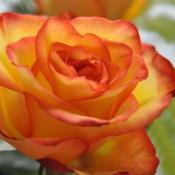

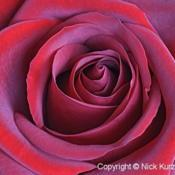

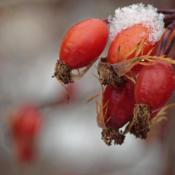

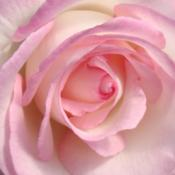

In [7]:
roses = data_dir+'/roses'

for file in os.listdir(roses):
    file_num = int(file.split('_')[1].split('.')[0])
    if file_num < 4:
        filename=roses+'/'+file
        i = Image(filename=filename) 
        display(i)